# Full Waveform Inversion of Flow and Temperature Fields on Synthetic Data
#### Inputs: 
True Waveform Data *where all sources are fired simultaneously within one aquisition*, Sourcetime Function and Scaling Paramters

#### Outputs: 
Reconstructed Fields and Misfit History

In [1]:
#import standard packages
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Import specific packages
import h5py
import sys
from matplotlib import gridspec 
import os # for file administration
import time
from scipy.interpolate import RectBivariateSpline

# Add the folder containing .py files to the Python path
sys.path.append(
    '../Scripts')

# Import Custom Modules
import WaveProp_on_cuda
import InverseUtils
import AnimateWaves
import AnimateGradients
import SourceTimeFuncs
import L_BFGS
import Plotting

def L2_misfit(p, p0):
    f = 1/2*np.sum((p-p0)**2)*dt
    return f

### Constitutive Relation

In [3]:
CR = "IdealGas"

# Import relevant CR:
sys.path.append(
    '../ConstitutiveRelationships')

if CR == 'IdealGas':
    from CR_IdealGas import c2
    from CR_IdealGas import c_inv
    # typical soundspeed
    c0 = 346     # [m/s]       
else:
    print('wrong constituive relationship')

### Import True Waveform Data 
Read the data produced from the simulation

In [4]:
# Choose folder
folder = "../../Data/Full-Waveform Data and Reconstructions/Wiens 4x4"

In [5]:
# load true data
h5_data = folder+"/Data_SimAqu_mediumSTF.h5"
print('True Data:', h5_data)
h=h5py.File(h5_data,"r")

# import true waveforms
#----------------------
seism0 = h["seism"][:,:].copy()
dt = h["dt"][()]
h.close()

# number of timesteps
nt = seism0.shape[1]

True Data: ../../Data/Full-Waveform Data and Reconstructions/Wiens 4x4/Data_SimAqu_mediumSTF_Tr.h5


### Input Scaling and Sourcetimefunction
For now, read from synthetic data as well

In [6]:
# Read from Synthetic Data
print('True Data:', h5_data)
h=h5py.File(h5_data,"r")

# import true waveforms
#----------------------
Ma = h["Ma"][()]
T0 = h["T0"][()]
DeltaT0 = h["DeltaT0"][()]

sourcetf = h["sourcetf"][:,:].copy()
h.close()

True Data: ../../Data/Full-Waveform Data and Reconstructions/Wiens 4x4/Data_SimAqu_mediumSTF_Tr.h5


### Define Prior Model and Simulation Parameters
For now, read geometry from true model

In [7]:
# Were any inversion iterations performed before?
n_iter = 0

nT_iter = 0 # of which where for DeltaT
nV_iter = 0 # of which where for v

In [8]:
# load model model geometry (for also from synthetic data)
print('Model Geometry from:', h5_data)
h=h5py.File(h5_data,"r")
nx, ny = h["DeltaT"][:,:].copy().shape
dh = h["dh"][()]
ijsrc = h["srcij"][:,:].copy()
ijrec = h["recij"][:,:].copy()
h.close()

#############################
# initialize prior model
# Here, also an estimated model from a previous inversion can be chosen as the starting point of this inversion
m_prior = np.zeros((3,nx,ny))

if n_iter != 0:
    # load prior model
    h5_data = folder + "/Data_m"+str(n_iter)+"_SimAqu.h5"
    
    print('Prior Model from:', h5_data)
    h=h5py.File(h5_data,"r")
    
    m_prior[0,:,:] = h["DeltaT"][:,:].copy()
    m_prior[1,:,:] = h["vx"][:,:].copy()
    m_prior[2,:,:] = h["vy"][:,:].copy()
    h.close()

#############################

# obtain grid
x = np.arange(0,nx)*dh
y = np.arange(0,ny)*dh

# Initialize input parameter dictionary for prior simulations
inpar = {}
inpar["ntimesteps"] = nt
inpar["nx"] = nx
inpar["ny"] = ny
inpar["dt"] = dt
inpar["dh"] = dh
inpar["T0"] = T0            
inpar["DeltaT0"] = DeltaT0 
inpar["Ma"] = Ma
inpar["savesnapshot"] = False
inpar["snapevery"] = 1000
inpar["comp_fact"] = 4 # compression factor for saved wavefields (insert divider of both nx and ny)
inpar["savefinal"] = True
inpar["freesurface"] = False
inpar["boundcond"] = "ReflBou"
inpar["constrel"] = CR

v_inc = 40 # FIX THIS PART WHEN FIXING PLOTTING!
#********************
if np.any(m_prior): # Plot Prior Model
    plt.figure(figsize=[8, 6])
    im = plt.pcolormesh(x,y,m_prior[0,:,:].T, cmap="plasma")
    plt.plot(ijsrc[0, :]*dh, ijsrc[1, :]*dh, "*w", markersize = 15, label = 'Sources')
    plt.plot(ijrec[0, :]*dh, ijrec[1, :]*dh, ".c", label = 'Receivers')
    plt.quiver(x[::v_inc],y[::v_inc],m_prior[1,::v_inc,::v_inc].T, m_prior[2,::v_inc,::v_inc].T, pivot = 'middle', width = 0.0015, color = 'lightsteelblue')
    plt.xlabel("x-Position")
    plt.ylabel("y-Position")
    plt.title("Flow and Temperature Prior Model")
    plt.colorbar(im, fraction=0.046*(10/16), pad=0.04, label = '$\\Delta T$')
    plt.gca().set_aspect('equal')
    plt.legend(loc = 'center left')
    plt.show()

Model Geometry from: ../../Data/Full-Waveform Data and Reconstructions/Wiens 4x4/Data_SimAqu_mediumSTF_Tr.h5


## Run Full-Waveform Inversion from here
If no prior data is available, perform first forward simulation and adjoint run.

In [9]:
# Generate Waveforms and Gradient from Prior?
Run_Prior_Simulation = True
#********************************************

if Run_Prior_Simulation:
    # forward run
    seism, psave, p_final = WaveProp_on_cuda.solveacoustic2D(inpar, ijsrc, m_prior, sourcetf, ijrec,
                                                                 outfileh5 = folder+'/Data_m0_SimAqu.h5')
    # Compute Initial Misfit
    Chi_0 = L2_misfit(seism0, seism)
    
    # computing the adjoint source
    adj_src = InverseUtils.adjointsource_L2(seism0, seism)

    inpar["savesnapshot"] = False
    inpar["snapevery"] = 100
    
    # compute gradient
    grad_old = InverseUtils.computegrad2D(inpar, ijrec, m_prior, adj_src,
                                       p_final, saveh5=True,
                                       outfileh5=folder+"/Gradient_m0_SimAqu.h5")
    
else:
    # read prior waveforms
    h5_data = folder+"/Data_m"+str(n_iter)+"_SimAqu.h5"
    print('Prior Model Data:', h5_data)
    h=h5py.File(h5_data,"r")

    #----------------------------
    seism = h["seism"][:,:].copy()
    h.close()

    Chi_0 = L2_misfit(seism0,seism)
    
    # read gradients and adjoint source
    grad_old = np.zeros((3,nx,ny))
    h5_data = folder+"/Gradient_m"+str(n_iter)+"_SimAqu.h5"
    print('Gradient from:', h5_data)
    h=h5py.File(h5_data,"r")
    
    grad_old[0,:,:] = h["gradient_c"][:,:].copy()
    grad_old[1,:,:] = h["gradient_vx"][:,:].copy()
    grad_old[2,:,:] = h["gradient_vy"][:,:].copy()
    
    # adjoint source:
    adj_src = h["srctf"][:,:].copy()
    adj_src = adj_src[:,::-1]
    
    h.close()

print("Initial Misfit: %.3e" %Chi_0)

Starting ACOUSTIC solver with reflective boundaries all around.
 Stability criterion, CFL number: 0.08694588666716857
Processing on cuda:0
 Time step 139900 of 140000 
Saved acoustic simulation and parameters to  ../../Data/Full-Waveform Data and Reconstructions/Wiens 4x4/Data_m0_SimAqu_Tr.h5
Starting GRADIENT computation using ADJOINT simulation.
 Time step 139900 of 140000 
Saved acoustic simulation and parameters to  ../../Data/Full-Waveform Data and Reconstructions/Wiens 4x4/Gradient_m0_SimAqu_Tr.h5
Initial Misfit: 3.250e-01


## Defining Arrays to control the inversion
The i-th element in `for_Temperature` and `for_Velocity` defines wether the respective quantity should be updated in the i-th iteration.\
`cut_sensors` defines wether the sensor should be cut out in the gradients before filtering\
The i-th element in `filter_Temperature` and `filter_Velocity` define the width (in wavelengths) of the Gaussian Kernel applied to smooth the gradient of the i-th iteration.

In [10]:
# For DeltaT
for_Temperature = [True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]
# For v
for_Velocity = [False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]

cut_sensors = False
# number of gridpts at which gradients are fixed to zero around sensors
sigma_cut = 4/dh


# Apply Gaussian Smoothing kernel with standard deviation 'filter' [wavelengths]
filter_Temperature = [5, 4, 3, 3, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0.5, 0.5, 0.5]
filter_Velocity = [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]

assert(len(for_Temperature)+1 == len(filter_Temperature))
assert(len(for_Velocity)+1 == len(filter_Velocity))

print(np.sum(for_Temperature))
print(np.sum(for_Velocity))

17
0


Plot the initial gradient after post processing: 

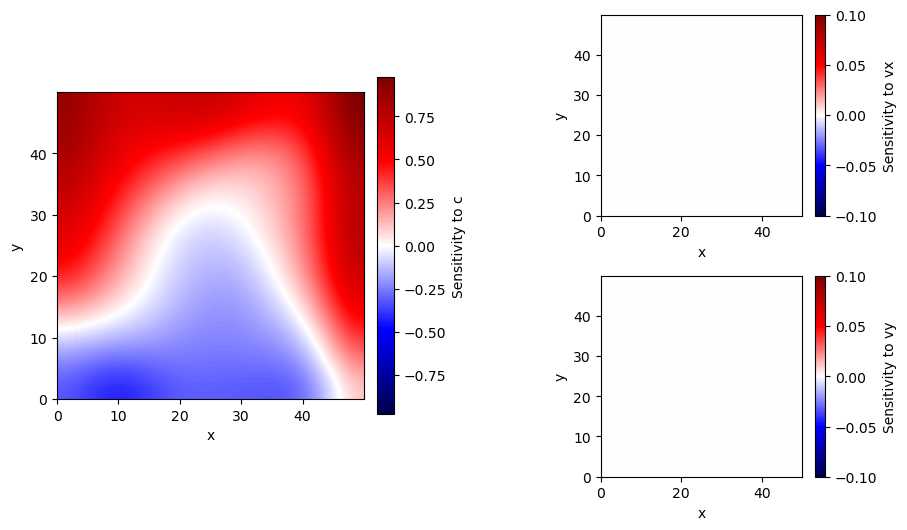

In [11]:
if cut_sensors:
        grad_old[1,:,:] = grad_old[1,:,:]*InverseUtils.sens_cutmask(nx, ny, ijrec, sigma_cut)
        grad_old[2,:,:] = grad_old[2,:,:]*InverseUtils.sens_cutmask(nx, ny, ijrec, sigma_cut)
    
# Smooth first gradients - padded by 1WL of zeros at the Boundary
grad_old[0,:,:] = InverseUtils.filter_SepGaussian(grad_old[0,:,:], dh, lambda_min = filter_Temperature[n_iter])
grad_old[1,:,:] = InverseUtils.filter_SepGaussian(grad_old[1,:,:], dh, lambda_min = filter_Velocity[n_iter])
grad_old[2,:,:] = InverseUtils.filter_SepGaussian(grad_old[2,:,:], dh, lambda_min = filter_Velocity[n_iter])

# display gradient:
Plotting.PlotGradient(x,y,grad_old)

#### Read/Initialise Misfit History and Curvature Information $w_k$ and $s_k$
It is necessary to store some information on the misfit and gradient evolution for the L-BFGS. For that, input how many iterations have been performed before this run.

In [12]:
if n_iter == 0:
    # Initialize Misfit History
    Chi_hist = np.array([Chi_0])
    
    # Initialise arrays for storing curvature information:
    w_c = np.array([], dtype = float).reshape((nx,ny,0))
    s_c = np.array([], dtype = float).reshape((nx,ny,0))
    w_vx = np.array([], dtype = float).reshape((nx,ny,0))
    s_vx = np.array([], dtype = float).reshape((nx,ny,0))
    w_vy = np.array([], dtype = float).reshape((nx,ny,0))
    s_vy = np.array([], dtype = float).reshape((nx,ny,0))
    
else:
    # Load Prior Curvature Information
    h5_data = folder + "/Iteration-"+str(n_iter)+"_SimAqu.h5"
    print('s&w from:', h5_data)
    h=h5py.File(h5_data,"r")
    
    # Misfit History
    Chi_hist = h["Misfit_history"][:].copy()
    
    # Curvature info
    w_c = h["w_c"][:,:].copy()
    s_c = h["s_c"][:,:].copy()
    w_vx = h["w_vx"][:,:].copy()
    s_vx = h["s_vx"][:,:].copy()
    w_vy = h["w_vy"][:,:].copy()
    s_vy = h["s_vy"][:,:].copy()
    h.close()

### Kick off the Gradient-Descend:

Specify some paramateres before:\
`c1` and `c2` are parameters related to the Wolfe Conditions (See Nocedal and Wright [1999])\
`m_max` determines how many consecutive gradients should be considered to approximate the Hessian.

In [13]:
c_1 = 1e-4 # factor for first Wolfe Condition
c_2 = 0.8  # factor for second Wolfe Condition
m_max = 3  # maximum number of gradients considerated for Hessian

k_max = len(for_Velocity) # count of final model (prior model is k = 0)

The following cell encorporates the workflow of the FWI:
<ol>
    <li> Update the model $m_k$ to $m_{k+1}$
    <li> Compute new forward waveforms $p(m_{k+1})$ with the updated model
    <li> Compute new adjoint source $p_0 - p(m_{k+1})$ and, with it, the new gradient $K_{m,k+1}$
    <li> Check wether the Wolfe Conditions are satisfied, i.e., is the step length too large or too small? If one of the conditions is violated, change the step length accordingly repeat steps 1-3.
    <li> Store inversion information (Misfit, Previous Gradients and Models...) in an additional file <font color="darkred">"Iteration_{k+1}"</font>.
    <li> $k \rightarrow k+1$
</ol>

In [14]:
# Initialize first iteration
m_old = m_prior
Chi_old = Chi_0

start_time = time.time()
# Starting the L-BFGS:
for k in range(n_iter,k_max):
    save_appendix = str(k+1)+"_SimAqu.h5"
    print("***")
    print("Iteration %i" %(k+1))
    print("***")
    
    # initialize new model
    m_new = np.zeros((3,nx,ny))
    
    m_new[0,:,:] = m_old[0,:,:]
    m_new[1,:,:] = m_old[1,:,:]
    m_new[2,:,:] = m_old[2,:,:]

    #+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
    # 1) Update current model m_k -> m_k+1:
    
    if for_Temperature[k]: # Temperature Update
        # Update in c-Space:
        m_new[0,:,:] = np.sqrt(c2(m_new[0,:,:],T0,DeltaT0))
        #-----------------------------------
        
        if nT_iter == 0:
            Deltac_max = np.sqrt(c2(1, T0, DeltaT0))-1
            gamma_c = Deltac_max/np.max(np.abs(grad_old[0,:,:]))/4
        else:
            gamma_c = np.sum(s_c[:,:,-1]*w_c[:,:,-1])/np.sum(w_c[:,:,-1]*w_c[:,:,-1])
    
        p_ck = L_BFGS.compute_stepdir(grad_old[0,:,:], s_c, w_c, gamma_c)
        alpha_ck = 1
        # update model
        m_new[0,:,:] += alpha_ck*p_ck
        
        # Transform back to DT-Space 
        m_new[0,:,:] = c_inv(m_new[0,:,:], T0, DeltaT0)
        #------------------------------------
        nT_iter +=1
        
    if for_Velocity[k]: # Velocity Update
        if nV_iter == 0:
            gamma_vx = 1/np.max(np.abs(grad_old[1,:,:]))/8
            gamma_vy = 1/np.max(np.abs(grad_old[2,:,:]))/8
        else:
            gamma_vx = np.sum(s_vx[:,:,-1]*w_vx[:,:,-1])/np.sum(w_vx[:,:,-1]*w_vx[:,:,-1])
            gamma_vy = np.sum(s_vy[:,:,-1]*w_vy[:,:,-1])/np.sum(w_vy[:,:,-1]*w_vy[:,:,-1])
    
        # step in vx-space
        p_vxk = L_BFGS.compute_stepdir(grad_old[1,:,:], s_vx, w_vx, gamma_vx)
        alpha_vxk = 1
        #step in vy-space
        p_vyk = L_BFGS.compute_stepdir(grad_old[2,:,:], s_vy, w_vy, gamma_vy)
        alpha_vyk = 1
        
        # update model
        m_new[1,:,:] += alpha_vxk*p_vxk
        m_new[2,:,:] += alpha_vyk*p_vyk
        nV_iter += 1

    #+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
    # 2) Compute new forward waveforms with the updated model
    inpar["savefinal"] = True
    # Run the simulation with all sources firing
    seism_new, psave_new, p_final = WaveProp_on_cuda.solveacoustic2D(inpar, ijsrc, m_new, sourcetf, ijrec,
                                                                     outfileh5 = folder+'/Data_m'+save_appendix)
    
    Chi_new = L2_misfit(seism_new, seism0)
    print('Misfit after iteration'+str(k+1)+': ', Chi_new)

    #+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
    # 3) Compute new adjoint source and corresponding gradient
    
    # computing the adjoint source
    adj_src = InverseUtils.adjointsource_L2(seism0, seism_new)
    adj_src[:,0:7500] *= 0 # Silencing Source Signals
    # compute gradient
    grad_new = InverseUtils.computegrad2D(inpar, ijrec, m_new, adj_src,
                                       p_final, saveh5=True,
                                       outfileh5=folder+"/Gradient_m"+save_appendix)
    
    # Gradient Post-Processing
    if cut_sensors:
        grad_new[1,:,:] = grad_new[1,:,:]*InverseUtils.sens_cutmask(nx, ny, ijrec, sigma_cut)
        grad_new[2,:,:] = grad_new[2,:,:]*InverseUtils.sens_cutmask(nx, ny, ijrec, sigma_cut)
    
 
    grad_new[0,:,:] = InverseUtils.filter_SepGaussian(grad_new[0,:,:], dh, lambda_min = filter_Temperature[k+1])
    grad_new[1,:,:] = InverseUtils.filter_SepGaussian(grad_new[1,:,:], dh, lambda_min = filter_Velocity[k+1])
    grad_new[2,:,:] = InverseUtils.filter_SepGaussian(grad_new[2,:,:], dh, lambda_min = filter_Velocity[k+1])
    
    #+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
    # 4) Check wether the Wolfe Conditions are satisfied

    # WOLFE CONDITIONS:
    if for_Temperature[k]:
        W0_c = Chi_new < Chi_old + c_1*alpha_ck*np.sum(grad_old[0,:,:]*p_ck)    # first Wolfe condition for c-update
        W1_c = np.sum(grad_new[0,:,:]*p_ck) >= c_2*np.sum(grad_old[0,:,:]*p_ck) # second Wolfe condition for c-update
    if for_Velocity[k]:
        W0_vx = Chi_new < Chi_old + c_1*alpha_vxk*np.sum(grad_old[1,:,:]*p_vxk)    # first Wolfe condition for vx-update
        W1_vx = np.sum(grad_new[1,:,:]*p_vxk) >= c_2*np.sum(grad_old[1,:,:]*p_vxk) # second Wolfe condition for vx-update
        W0_vy = Chi_new < Chi_old + c_1*alpha_vyk*np.sum(grad_old[2,:,:]*p_vyk)    # first Wolfe condition for vy-update
        W1_vy = np.sum(grad_new[2,:,:]*p_vyk) >= c_2*np.sum(grad_old[2,:,:]*p_vyk) # second Wolfe condition for vy-update
    
    #++++++++
    # Reiterate step length and recalculate gradients while not satisfied (repeat step 1)
    while (for_Temperature[k] and not (W0_c and W1_c)) or (for_Velocity[k] and not (W0_vx and W0_vy and W1_vx and W1_vy)):
        
        if for_Temperature[k]:
            # first Wolfe Condition:
            if not W0_c:
                print('First Wolfe Condition not satisfied for a_c', k)
                alpha_ck *= 0.4
        
            # Check second Wolfe Condition
            if not W1_c:
                print('Second Wolfe Condition not satisfied for a_c', k)
                alpha_ck *= 1.5
                
            # Update in c-Space:
            #-----------------------------------
            m_new[0,:,:] = np.sqrt(c2(m_old[0,:,:],T0,DeltaT0)) + alpha_ck*p_ck
            # Transform back to DeltaT-Space 
            m_new[0,:,:] = c_inv(m_new[0,:,:], T0, DeltaT0)
            #------------------------------------
                
        if for_Velocity[k]:
            # first Wolfe Condition:
            if not W0_vx:
                print('First Wolfe Condition not satisfied for a_vx', k)
                alpha_vxk *= 0.4
            if not W0_vy:
                print('First Wolfe Condition not satisfied for a_vy', k)
                alpha_vyk *= 0.4
        
            # Check second Wolfe Condition
            if not W1_vx:
                print('Second Wolfe Condition not satisfied for a_vx', k)
                alpha_vxk *= 1.5
            if not W1_vy:
                print('Second Wolfe Condition not satisfied for a_vy', k)
                alpha_vyk *= 1.5 

            # Update flow model
            m_new[1,:,:] = m_old[1,:,:] + alpha_vxk*p_vxk
            m_new[2,:,:] = m_old[2,:,:] + alpha_vyk*p_vyk
        
        #++++++++
        # Compute new seismograms and misfit (repeat step 2):
        inpar["savefinal"] = True
        # Run the simulation with all sources firing
        seism_new, psave_new, p_final = WaveProp_on_cuda.solveacoustic2D(inpar, ijsrc, m_new, sourcetf, ijrec,
                                                                             outfileh5 = folder+'/Data_m'+save_appendix)

        Chi_new = L2_misfit(seism_new, seism0)
        print('New misfit: ', Chi_new)

        #++++++++
        # Recompute the Gradient (repeat step 3)
        # computing the adjoint source
        adj_src = InverseUtils.adjointsource_L2(seism0, seism_new)
        adj_src[:,0:7500] *= 0 # Silencing Source Signals

        # compute gradient
        grad_new = InverseUtils.computegrad2D(inpar, ijrec, m_new, adj_src,
                                           p_final, saveh5=True,
                                           outfileh5=folder+"/Gradient_m"+save_appendix)
            
        # Gradient Post-Processing 
        if cut_sensors:
            grad_new[1,:,:] = grad_new[1,:,:]*InverseUtils.sens_cutmask(nx, ny, ijrec, sigma_cut)
            grad_new[2,:,:] = grad_new[2,:,:]*InverseUtils.sens_cutmask(nx, ny, ijrec, sigma_cut)

        grad_new[0,:,:] = InverseUtils.filter_SepGaussian(grad_new[0,:,:],dh, lambda_min = filter_Temperature[k+1])
        grad_new[1,:,:] = InverseUtils.filter_SepGaussian(grad_new[1,:,:],dh, lambda_min = filter_Velocity[k+1])
        grad_new[2,:,:] = InverseUtils.filter_SepGaussian(grad_new[2,:,:],dh, lambda_min = filter_Velocity[k+1])

        # Re-Evaluate Wolfe Conditions:
        if for_Temperature[k]:
            W0_c = Chi_new < Chi_old + c_1*alpha_ck*np.sum(grad_old[0,:,:]*p_ck)    # first Wolfe condition for c-update
            W1_c = np.sum(grad_new[0,:,:]*p_ck) >= c_2*np.sum(grad_old[0,:,:]*p_ck) # second Wolfe condition for c-update
        if for_Velocity[k]:
            W0_vx = Chi_new < Chi_old + c_1*alpha_vxk*np.sum(grad_old[1,:,:]*p_vxk)    # first Wolfe condition for vx-update
            W1_vx = np.sum(grad_new[1,:,:]*p_vxk) >= c_2*np.sum(grad_old[1,:,:]*p_vxk) # second Wolfe condition for vx-update
            W0_vy = Chi_new < Chi_old + c_1*alpha_vyk*np.sum(grad_old[2,:,:]*p_vyk)    # first Wolfe condition for vy-update
            W1_vy = np.sum(grad_new[2,:,:]*p_vyk) >= c_2*np.sum(grad_old[2,:,:]*p_vyk) # second Wolfe condition for vy-update
    
    #+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
    # Store Inversion Information in additional file
    
    # Save last Misfit
    Chi_hist = np.append(Chi_hist, Chi_new)
    
    # append w and s
    if for_Temperature[k]:
        w_c = np.dstack((w_c, grad_new[0,:,:] - grad_old[0,:,:]))
        s_c = np.dstack((s_c, np.sqrt(c2(m_new[0,:,:], T0, DeltaT0)) 
                       - np.sqrt(c2(m_old[0,:,:], T0, DeltaT0))))
        # delete too old information:
        if nT_iter >= m_max:
            w_c = w_c[:,:,1:]
            s_c = s_c[:,:,1:]
            
    if for_Velocity[k]:
        w_vx = np.dstack((w_vx, grad_new[1,:,:] - grad_old[1,:,:]))
        s_vx = np.dstack((s_vx, m_new[1,:,:] - m_old[1,:,:]))
        w_vy = np.dstack((w_vy, grad_new[2,:,:] - grad_old[2,:,:]))
        s_vy = np.dstack((s_vy, m_new[2,:,:] - m_old[2,:,:]))
        # delete too old information:
        if nV_iter >= m_max:
            w_vx = w_vx[:,:,1:]
            s_vx = s_vx[:,:,1:]
            w_vy = w_vy[:,:,1:]
            s_vy = s_vy[:,:,1:]
        

    # save information
    outfileh5 = folder + "/Iteration-"+save_appendix
    hf = h5py.File(outfileh5,"w")
    hf["w_c"] = w_c
    hf["s_c"] = s_c
    hf["w_vx"] = w_vx
    hf["s_vx"] = s_vx
    hf["w_vy"] = w_vy
    hf["s_vy"] = s_vy
    hf["Misfit_history"] = Chi_hist
    hf["T_filter"] = filter_Temperature
    hf["v_filter"] = filter_Velocity
    hf["for_Temperature"] = for_Temperature
    hf["for_Velocity"] = for_Velocity
    hf.close()
    print("Saved Inversion Information to ",outfileh5)

    end_time = time.time()
    print("Inversion Time: %f hours" %((end_time - start_time)/3600))
        
    #+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
    # k -> k+1
    m_old = m_new
    Chi_old = Chi_new
    grad_old = grad_new

***
Iteration 1
***
Starting ACOUSTIC solver with reflective boundaries all around.
 Stability criterion, CFL number: 0.08695244523054078
Processing on cuda:0
 Time step 139900 of 140000 
Saved acoustic simulation and parameters to  ../../Data/Full-Waveform Data and Reconstructions/Wiens 4x4/Data_m1_SimAqu_Tr.h5
Misfit after iteration1:  0.2618117566491623
Starting GRADIENT computation using ADJOINT simulation.
 Time step 139900 of 140000 
Saved acoustic simulation and parameters to  ../../Data/Full-Waveform Data and Reconstructions/Wiens 4x4/Gradient_m1_SimAqu_Tr.h5
Saved Inversion Information to  ../../Data/Full-Waveform Data and Reconstructions/Wiens 4x4/Iteration-1_SimAqu_Tr.h5
Inversion Time: 0.164919 hours
***
Iteration 2
***
Starting ACOUSTIC solver with reflective boundaries all around.
 Stability criterion, CFL number: 0.08698350306664403
Processing on cuda:0
 Time step 139900 of 140000 
Saved acoustic simulation and parameters to  ../../Data/Full-Waveform Data and Reconstruct